<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/P1C1_Sequence1_refinements/sequences/P1C1_BehaviourAsPolicy/P1C1_Sequence1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part 1 Behaviour, environments and optimization: evolution and learning**

### **Animals are adapted to their specific environments; their behaviour is best understood within the context of their evolutionary environment.**

### Objective: Part 1 of the book aims to introduce the fundamental concepts of
* ### **environment**, where an organism lives;
* ### **behaviour**, what the organism does there;
* ### **optimization**, how learning and evolution shape an organism's behaviour to make it better suited to its environment.

___
# Chapter 1.1 Behaviour as a policy in an environmental context

### Objective: This chapter develops examples of how behaviour is described and evaluated in relation to its [goodness](## "This is a very loaded term, to be unpacked carefully later") within a specific environmental niche.

You will learn:
*   What is a policy? A policy is a formalization of behaviour as a function that takes an organism's experiences of their environment as an input and outputs the organism's actions.
*   What is a good policy? The rewards and other environmental signals, resulting from the organism's actions in the environment, are integrated into a Loss/Objective function to evaluatate, and potentially improve, a policy.
*   What is stochasticity? Both the environment and an organism's behavior can contain random elements. This randomness can pose challenges when evaluating policies, as it becomes difficult to determine whether poor outcomes are due the policy itself or simply bad luck.



___
# **Sequence 1.1.1: Gridworld Introduction**

### Objective: In this sequence, we will create a simple environment-organism system to demonstrate how an organism's **behaviour**, within an **environment**, can be evaluated using **rewards**. We will also explore how intelligent behaviour can lead to better outcomes and how **randomness** can make evaluation of behaviour difficult.

# Setup



In [1]:
import ipywidgets as widgets
import threading
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import time
import asyncio
import logging
#import jax

!pip3 install vibecheck datatops > /dev/null 2> /dev/null #google.colab
from vibecheck import DatatopsContentReviewContainer

# set numpy random seed
SEED = 2021
rng = np.random.default_rng(seed=SEED)
#from google.colab import output as colab_output
#colab_output.enable_custom_widget_manager()

In [48]:
# @title Plotting Functions
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

def make_grid(num_rows, num_cols):
  """Plots an n_rows by n_cols grid with cells centered on integer indices and
  returns fig and ax handles for futher use
  Args:
    num_rows (int): number of rows in the grid (vertical dimension)
    num_cols (int): number of cols in the grid (horizontal dimension)

  Returns:
    fig (matplotlib.figure.Figure): figure handle for the grid
    ax: (matplotlib.axes._axes.Axes): axes handle for the grid
  """
  fig, ax = plt.subplots(figsize = (7,6), layout='constrained')
  ax.spines[['right', 'top']].set_visible(True)
  ax.set_xticks(np.arange(0, num_cols, 1))
  ax.set_yticks(np.arange(0, num_rows, 1))
  # Labels for major ticks
  ax.set_xticklabels(np.arange(0, num_cols, 1),fontsize=8)
  ax.set_yticklabels(np.arange(0, num_rows, 1)[::-1],fontsize=8)

  # Minor ticks
  ax.set_xticks(np.arange(0.5, num_cols-0.5, 1), minor=True)
  ax.set_yticks(np.arange(0.5, num_rows-0.5, 1), minor=True)

  ax.xaxis.tick_top()

  # Gridlines based on minor ticks
  ax.grid(which='minor', color='grey', linestyle='-', linewidth=2, alpha=0.5)

  # Remove minor ticks
  ax.tick_params(which='minor', bottom=False, left=False)

  ax.set_xlim(( -0.5, num_cols-0.5))
  ax.set_ylim(( -0.5, num_rows-0.5))
  return fig, ax

def plot_food(fig, ax, rc_food_loc, n_rows):
  food = ax.scatter([], [], s=150, marker='o', color='red', label='Food')
  rc_food_loc = np.array(rc_food_loc, dtype=int)
  rc_food_loc[:,0] = n_rows - 1 - rc_food_loc[:,0]
  food.set_offsets(np.fliplr(rc_food_loc))
  return food

def plot_critter(fig, ax, rc_critter_loc, n_rows):
  critter = ax.scatter([], [], s=250, marker='h', color='blue', label='Critter')
  r, c = rc_critter_loc
  critter.set_offsets((c, n_rows-1-r))
  return critter

In [3]:
# @title Simulation Functions, Variables and Widgets
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**

def init_loc(n_rows, n_cols, num):
  """Returns random 2d grid locations, without replacement,
  in both unravled/flat coordinates and as xy pairs"""
  int_loc = np.random.choice(n_rows * n_cols, num, replace=False)
  rc_loc = np.unravel_index(int_loc, (n_rows, n_cols))
  return int_loc, rc_loc


class GridworldBoard():
  """
  A collection methods and parameters of a gridworld game board that
  define the logic of the game.
  Board state is tracked as a triple (pieces, scores, rounds_left)
  pieces: batch_size x n_rows x n_cols np.array
  scores: batch_size np.array
  rounds_left: batch_size np.array

  Pieces are interpreted as:
  1=critter, -1=food, 0=empty

  First dim is batch, second dim row , third is col, so pieces[0][1][7]
  is the square in row 2, in column 8 of the first board in the batch of boards

  Note:
    In 2d np.array first dim is row (vertical), second dim is col (horizontal),
    i.e. top left corner is (0,0), so take care when visualizing/plotting
    as np.array visualization inline with typical tensor notation but at odds
    with conventional plotting where (0,0) is bottom left, first dim, x, is
    horizontal, second dim, y, is vertical
  """
  def __init__(self, batch_size=1,
               n_rows=7, n_cols=7,
               num_food=10, lifetime=30):
    """Set the parameters of the game."""
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.batch_size = batch_size
    self.num_food = num_food
    self.lifetime = lifetime


  def get_init_board_state(self):
    """Set up starting board using game parameters"""
    #set rounds_left and score
    self.rounds_left = np.ones(self.batch_size) * self.lifetime
    self.scores = np.zeros(self.batch_size)
    # create an empty board array.
    self.pieces = np.zeros((self.batch_size, self.n_rows, self.n_cols))
    # Place critter and initial food items on the board randomly
    for ii in np.arange(self.batch_size):
      # num_food+1 because we want critter and food locations
      int_loc, rc_loc = init_loc(self.n_rows, self.n_cols, self.num_food+1)
      # critter random start location
      self.pieces[(ii, rc_loc[0][0], rc_loc[1][0])] = 1
      # food random start locations
      self.pieces[(ii, rc_loc[0][1:], rc_loc[1][1:])] = -1
    return(self.pieces.copy(), self.scores.copy(), self.rounds_left.copy())


  def set_state(self, board):
    """ board is a triple of np arrays
    pieces,       - batch_size x n_rows x n_cols
    scores,       - batch_size
    rounds_left   - batch_size
    """
    self.pieces, self.scores, self.rounds_left = board


  def get_state(self):
    """ returns a board state, which is a triple of np arrays
    pieces,       - batch_size x n_rows x n_cols
    scores,       - batch_size
    rounds_left   - batch_size
    """
    return(self.pieces.copy(), self.scores.copy(), self.rounds_left.copy())


  def __getitem__(self, index):
    return self.pieces[index]


  def execute_moves(self, moves):
    """
    Updates the state of the board given the moves made.

    Args:
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new x coord for each critter
        on each board and the third gives the new y coord.

    Note:
      Assumes that there is exactly one valid move for each board in the
      batch of boards. i.e. it does't check for bounce/reflection on edges,
      or for multiple move made on the same board. It only checks for eating
      food and adds new food when appropriate. Invalid moves could lead to
      illegal teleporting behavior, critter dublication, or index out of range
      errors.
    This assumes the move is valid, i.e. doesn't check for
    bounce/reflection on edges, it only checks eating and adds new food,
    so invalid moves could lead to illegal teleporting behaviour or index out
    of range errors
    """
    assert len(moves[0]) == self.pieces.shape[0]
    #critters leave their spots
    self.pieces[self.pieces==1] = 0
    #which critters have food in their new spots
    eats_food = self.pieces[moves] == -1
    # some critters eat and their scores go up
    self.scores = self.scores + eats_food

    num_empty_after_eat = self.n_rows*self.n_cols - self.num_food
    # -1 for the critter +1 for food eaten
    # which boards in the batch had eating happen
    g_eating = np.where(eats_food)[0]
    new_food_sample = rng.choice(num_empty_after_eat, size=np.sum(eats_food))
    # add random food to replace what is eaten
    if np.any(eats_food):
      possible_new_locs = np.where(np.logical_and(
          self.pieces == 0, #the spot is empty
          eats_food.reshape(self.batch_size, 1, 1))) #food eaten on that board
      food_sample_ = rng.choice(num_empty_after_eat, size=np.sum(eats_food))
      food_sample = food_sample_ + np.arange(len(g_eating))*num_empty_after_eat
      assert np.all(self.pieces[(possible_new_locs[0][food_sample],
                                 possible_new_locs[1][food_sample],
                                 possible_new_locs[2][food_sample])] == 0)
      #put new food on the board
      self.pieces[(possible_new_locs[0][food_sample],
                   possible_new_locs[1][food_sample],
                   possible_new_locs[2][food_sample])] = -1
    # put critters in new positions
    self.pieces[moves] = 1.0
    self.rounds_left = self.rounds_left - 1
    assert np.all(self.pieces.sum(axis=(1,2)) == ((self.num_food * -1) + 1))


  def get_legal_moves(self):
    """Identifies all legal moves for the critter, taking into acount
    bouncing/reflection at edges,

    Returns:
      A numpy int array of size batch x 3(g,x,y) x 4(possible moves)

    Note:
      moves[0,1,3] is the x coordinate of the move corresponding to the
      fourth offstet on the first board.
      moves[1,:,1] will give the g,x,y triple corresponding to the
      move on the second board and the second offset, actions are integers
    """

    #apply all possible offsets to each game
    moves = np.stack([
      np.array(np.where(self.pieces == 1)) +
        np.array([np.array([0,  1, 0])]*self.batch_size).T,
      np.array(np.where(self.pieces == 1)) +
        np.array([np.array([0, -1, 0])]*self.batch_size).T,
      np.array(np.where(self.pieces == 1)) +
        np.array([np.array([0, 0,  1])]*self.batch_size).T,
      np.array(np.where(self.pieces == 1)) +
        np.array([np.array([0, 0, -1])]*self.batch_size).T]).swapaxes(0,2)

    #check bounces at boundaries
    moves[:,1,:] = np.where(moves[:,1,:] >=
                            self.n_rows, self.n_rows-2, moves[:,1,:])
    moves[:,2,:] = np.where(moves[:,2,:] >=
                            self.n_cols, self.n_cols-2, moves[:,2,:])
    moves[:,1,:] = np.where(moves[:,1,:] < 0, 1, moves[:,1,:])
    moves[:,2,:] = np.where(moves[:,2,:] < 0, 1, moves[:,2,:])
    return moves




class GridworldGame():
  """
  A collection methods and parameters of a gridworld game that allow
  for interaction with and display of GridwordlBoard objects.
  """
  square_content = {
      -1: "X", #Food
      +0: "-", #Nothing
      +1: "O"  #Critter
      }

  def get_square_piece(self, piece):
    return GridworldGame.square_content[piece]


  def __init__(self, batch_size, n_rows, n_cols, num_food, lifetime):
    self.batch_size = batch_size
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.num_food = num_food
    self.lifetime = lifetime


  def get_init_board(self):
    """
    Generates a starting board given the parameters of the game.
    Returns a tuple giving current state of the game
    """
    # current score, and rounds left in the episode
    b = GridworldBoard(self.batch_size, self.n_rows, self.n_cols,
                       self.num_food, self.lifetime)
    return b.get_init_board_state()


  def get_board_size(self):
    """Shape of a sinlge board, doesn't give batch size"""
    return (self.n_rows, self.n_cols)


  def get_action_size(self):
    """
    Returns the number of all possible actions, even though only  2-4 of
    these will ever be valid on a given turn.
    Actions correspond to integer indexes of board locations,
    moves to g,x,y coordinate indexes of board locations
    """
    return self.n_rows * self.n_cols


  def get_batch_size(self):
    """
    Returns the number of actions, only 2-4 of these will ever be valid.
    Actions correspond to integer indexes of board locations,
    moves to x,y indexes of board locations
    """
    return self.batch_size


  def string_rep(self, board, g):
    """ A bytestring representation board g's state in the batch of boards"""
    return board[0][g].tobytes() + board[1][g].tobytes() + board[2][g].tobytes()


  def string_rep_readable(self, board, g):
    """ A human readable representation board g's state in the batch of boards"""
    board_s = "".join([self.square_content[square] for row in board[0][g] for square in row])
    board_s = board_s + '_' + str(board[1][g])
    board_s = board_s + '_' + str(board[2][g])
    return board_s


  def get_scores(self, board):
    return board[1].copy()


  def get_rounds_left(self, board):
    return board[2].copy()


  def display(self, board, g):
    """Dispalys the g-th games in the batch of boards"""
    print("   ", end="")
    for y in range(self.n_cols):
      print(y, end=" ")
    print("")
    print("-----------------------")
    for y in range(self.n_cols):
      print(y, "|", end="")    # Print the row
      for x in range(self.n_rows):
        piece = board[0][g][y][x]    # Get the piece to print
        print(GridworldGame.square_content[piece], end=" ")
      print("|")
    print("-----------------------")
    print("Rounds Left: " + str(board[2][g]))
    print("Score: " + str(board[1][g]))


  def get_valid_actions(self, board):
    """
    A Helper function to translate the g,x,y, tuples provided the
    GridworldBoard.get_legal_moves method into valid actions, represented
    as binary vectors of len num_actions.

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size

    Returns:
      valids: np.ndarray(binary) batch_size x num_actions, 1's represent
              valid moves
    """
    batch_size, n_rows, n_cols = board[0].shape
    b = GridworldBoard(batch_size, n_rows, n_cols,
                       self.num_food, self.lifetime)
    b.set_state(board)
    legal_moves =  b.get_legal_moves()
    valids = np.zeros((batch_size, n_rows * n_cols))
    for ii, g in enumerate(legal_moves[:,1:,:]):
      for x,y in zip(g[0],g[1]):
        valids[ii, x*self.n_cols+y] = 1
    return valids


  def display_moves(self, board, g):
    """Dispaly possible moves for the g-th games in the batch of boards"""
    batch_size, n_rows, n_cols = board[0].shape
    A=np.reshape(self.get_valid_actions(board)[g], (n_rows, n_cols))
    print("  ")
    print("possible moves")
    print("   ", end="")
    for y in range(self.n_cols):
      print(y, end=" ")
    print("")
    print("-----------------------")
    for y in range(self.n_cols):
      print(y, "|", end="")    # Print the row
      for x in range(self.n_rows):
        piece = A[y][x]    # Get the piece to print
        print(GridworldGame.square_content[piece], end=" ")
      print("|")
    print("-----------------------")


  def get_next_state(self, board, actions, a_indx=None):
    """
    Helper function using GridworldBoard.execute_moves to update board state
    given actions on a batch of boards


    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      actions: list of integer indexes of critter's new board positions
      a_indx: list of integer indexes indicating which actions are being taken
        on which boards in the batch

    Returns:
      a board tiple signifying next state

    Note:
      if len(actions) > batch_size of board the returned board state will have
      an expanded batch size, allowing multiple paths in the game tree to be
      explored in parellel

    """
    batch_size, n_rows, n_cols = board[0].shape
    if board[2][0] <= 0:
      # assumes all boards in the batch have the same rounds left
      # no rounds left return the board unchanged
      return board
    else:
      moves = (np.arange(len(actions)),
               np.floor_divide(actions, n_cols),
               np.remainder(actions, n_cols))
      b = GridworldBoard(len(actions), n_rows, n_cols,
                         self.num_food, self.lifetime)
      if a_indx is None:
        # just one move on each board in the batch
        assert batch_size == len(actions)
        b.set_state(board)
      else:
        # potentially multiple moves on each board, expand the batch
        assert len(actions) == len(a_indx)
        newPieces = np.array([board[0][ai].copy() for ai in a_indx])
        newScores = np.array([board[1][ai].copy() for ai in a_indx])
        newrounds_left = np.array([board[2][ai].copy() for ai in a_indx])
        b.set_state((newPieces, newScores, newrounds_left))
      b.execute_moves(moves)
      return b.get_state()


  def get_game_ended(self, board):
    """
    Helper function to signify if game has ended

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size

    Returns:
      batch size np.array of -1 if not ended, and scores for
      each game in the batch if it is ended
    """
    rounds_left = board[2]
    scores = board[1]
    if np.any(rounds_left >= 1):
      return np.ones(self.batch_size) * -1.0
    else:
      return scores


def init_state(n_rows=7,
              n_cols=7,
              num_food=10,
              rc_critter=None):
  state = {'num_moves': 0,
           'num_eats': 0,
           'num_food': num_food,
           'rc_food_loc': np.array([[]]),
           'int_food_loc': np.array([]),
           'n_rows': n_rows,
           'n_cols': n_cols}

  #randomly initialize food locations
  if num_food > n_rows * n_cols -1:
    state['num_food'] = n_rows * n_cols -1
  state['int_food_loc'], state['rc_food_loc'] = init_loc(state['n_rows'],state['n_cols'],state['num_food'])

  if rc_critter is None:
    # put critter roughly in the middle
    state['rc_critter_loc'] = np.array([[np.floor(state['n_rows']/2), np.floor(state['n_cols']/2)]], dtype=int)
    state['int_critter_loc'] = np.ravel_multi_index((state['rc_critter_loc'][:,0],state['rc_critter_loc'][:,1]), (state['n_rows'], state['n_cols']))
  else:
    state['rc_critter_loc'] = np.array(rc_critter).reshape((1,2))
    state['int_critter_loc'] = np.ravel_multi_index((state['rc_critter_loc'][:,0],state['rc_critter_loc'][:,1]), (state['n_rows'], state['n_cols']))
  return state

state = init_state()

def update_critter_location(x, y):
  state['num_moves'] = state['num_moves'] + 1
  state['rc_critter_loc'] = np.array([[x,y]])
  state['int_critter_loc'] = np.ravel_multi_index((state['rc_critter_loc'][:,0],state['rc_critter_loc'][:,1]), (state['n_rows'], state['n_cols']))

def eating():
  # is the critter on a food patch
  if state['int_critter_loc'][0] in set(state['int_food_loc']):
    #critter is on a food patch
    state['num_eats'] = state['num_eats'] + 1
    # figure out where the new food will go where there isn't already food
    new_food_loc = np.random.choice(list(set(np.arange(state['n_rows']*state['n_cols'])) - set(state['int_food_loc'])))
    #remove the eaten food
    new_food_loc_set = set(state['int_food_loc'])
    new_food_loc_set.remove(state['int_critter_loc'][0])
    # add the new food
    new_food_loc_set.add(new_food_loc)

    #update state
    state['int_food_loc'] = np.array(np.sort(list(new_food_loc_set)))
    state['rc_food_loc'] = np.vstack(np.unravel_index(state['int_food_loc'], (state['n_rows'], state['n_cols']))).T
    state['eating_string'] = ('You ate the food here, new food at ' + str(np.unravel_index(new_food_loc, (state['n_rows'], state['n_cols']))))
  else:
    state['eating_string'] = 'No food here'

def update_state(x, y):
  update_critter_location(x, y)
  eating()
  #print(state_dict['food_locationssUnravel'])

output = widgets.Output()

def plot_fig_from_scratch():
  fig, ax = make_grid(state['n_rows'], state['n_cols'])
  plot_food(fig, ax, state['rc_food_loc'])
  plot_critter(fig, ax, state['rc_critter_loc'])
  fig.legend(loc = "outside right upper")
  plt.show()

up_button = widgets.Button(description="Up")
down_button = widgets.Button(description="Down")
left_button = widgets.Button(description="Left")
right_button = widgets.Button(description="Right")
random_movement = widgets.Checkbox(
    value=False,
    description='Move Randomly',
    disabled=False,
    indent=False
)

def random_click():
  move = np.random.randint(0,4)
  if move == 0:
    up_button.click()
  elif move == 1:
    down_button.click()
  elif move == 2:
    left_button.click()
  elif move == 3:
    right_button.click()
  else:
    print('should not happen')


class Timer:
  def __init__(self, timeout, callback):
    self._timeout = timeout
    self._callback = callback
  async def _job(self):
    await asyncio.sleep(self._timeout)
    self._callback()
  def start(self):
    self._task = asyncio.ensure_future(self._job())
  def cancel(self):
    self._task.cancel()

click_timer = Timer(5.0, random_click)

def button_output_update(which_button, x, y):
  with output:
    if random_movement.value == True:
      if hasattr(click_timer, '__Task'):
        click_timer.cancel()
    output.clear_output(wait=True)
    print("Moved " + which_button + ". " + "Criter is now at ({}, {}).".format(x,y))
    print(state['eating_string'])
    print("Moves: {0} \tFood Eaten: {1} \tFood Per Move: {2}".format(state['num_moves'], state['num_eats'], state['num_eats'] / state['num_moves']))
    plot_fig_from_scratch()
    if random_movement.value == True:
      click_timer.start()

def on_up_button_clicked(b):
  which_button = 'up'
  x = state['rc_critter_loc'][0][0]
  y = state['rc_critter_loc'][0][1]
  if y >= state['n_cols']-1:
    y = state['n_cols'] - 2
  elif y < state['n_cols']-1:
    y = y+1
  update_state(x, y)
  button_output_update(which_button, x, y)

def on_down_button_clicked(b):
  which_button = 'down'
  x = state['rc_critter_loc'][0][0]
  y = state['rc_critter_loc'][0][1]
  if y > 0 :
    y = y-1
  elif y <= 0:
    y = 1
  update_state(x, y)
  button_output_update(which_button, x, y)

def on_left_button_clicked(b):
  which_button = 'left'
  x = state['rc_critter_loc'][0][0]
  y = state['rc_critter_loc'][0][1]
  if x > 0 :
    x = x-1
  elif x <= 0:
    x = 1
  update_state(x, y)
  button_output_update(which_button, x, y)

def on_right_button_clicked(b):
  which_button = 'right'
  x = state['rc_critter_loc'][0][0]
  y = state['rc_critter_loc'][0][1]
  if x >= state['n_rows']-1:
    x = state['n_rows'] - 2
  elif x < state['n_rows']-1:
    x = x+1
  update_state(x, y)
  button_output_update(which_button, x, y)

up_button.on_click(on_up_button_clicked)
down_button.on_click(on_down_button_clicked)
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

In [4]:
gwb = GridworldBoard(batch_size=4)
gwb.get_init_board_state()

(array([[[ 0.,  0.,  0.,  0., -1.,  0., -1.],
         [ 0.,  0.,  0., -1.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0., -1., -1.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0., -1.,  0.,  0.],
         [ 0., -1.,  1., -1., -1.,  0.,  0.],
         [ 0.,  0.,  0., -1.,  0.,  0.,  0.]],
 
        [[ 0.,  0.,  0., -1., -1.,  0.,  0.],
         [-1., -1.,  0., -1.,  0.,  0.,  0.],
         [ 0.,  1.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0., -1.],
         [ 0.,  0.,  0., -1.,  0., -1.,  0.],
         [ 0.,  0.,  0.,  0., -1.,  0., -1.]],
 
        [[ 0.,  0., -1.,  0., -1.,  0., -1.],
         [ 0.,  0., -1.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0., -1.,  0.,  0., -1.],
         [ 0.,  0.,  0.,  0., -1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0., -1.],
         [-1.,  0.,  0.,  0.,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0., -1.,  0.]],
 
        [[-1.,  0.,  0., 

In [5]:
moves = gwb.get_legal_moves()

In [6]:
moves[1,:,1]

array([1, 1, 1])

In [7]:
# @title Other Helper Functions
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**

class dotdict(dict):
  def __getattr__(self, name):
    return self[name]

def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()

# Micro 1.1.1.1: Initializing Gridworld

Before we introduce an organism with **behaviour** we're going to build an **environment** for them to behave in. To start, this world will consist of a 7 x 7 grid of cells. Let's make a picture of that and see what it looks like.

In [8]:
############################################################################
## TO DO for students: replace ... with the correct arguments(inputs) is the
## make_grid function below to a grid the right size and shape. You can use the
## tool tip by hovering over the word make_grid to find out how to use it. You
## can also use the tool tip to view the source code. How does it work?
raise NotImplementedError("Student exercise: make grid using the make_grid function")
############################################################################

fig, ax = make_grid(...)

NotImplementedError: ignored

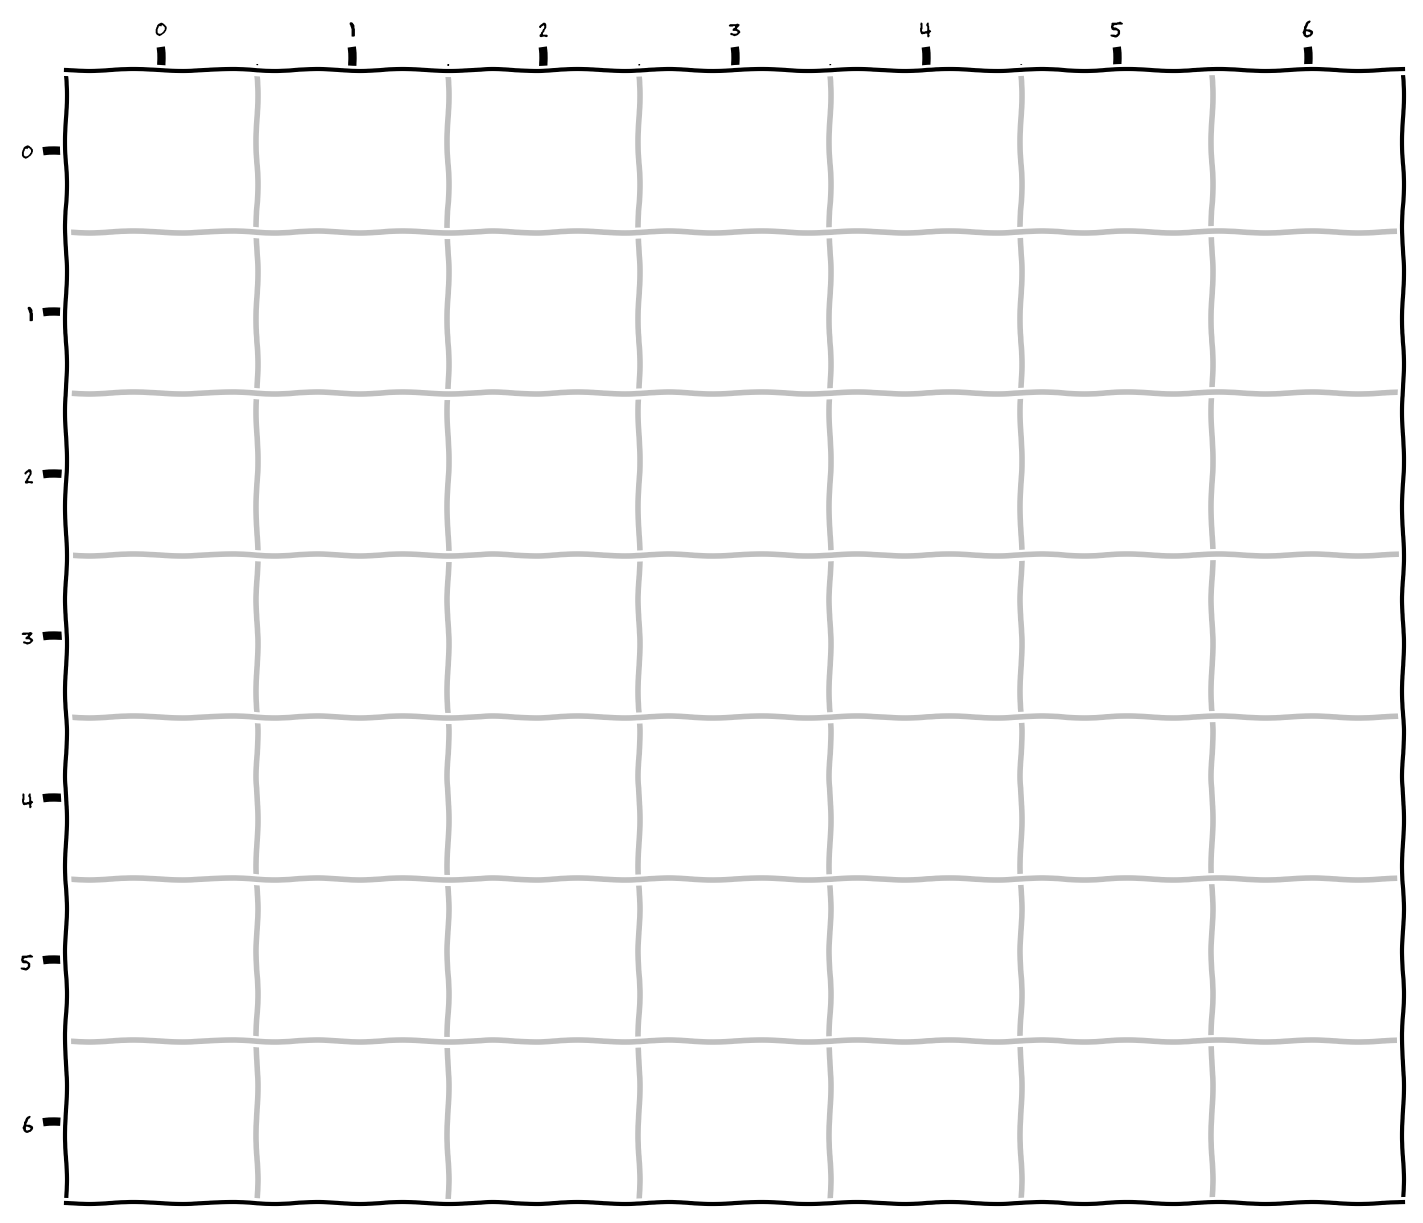

In [12]:
# to_remove solution

with plt.xkcd():
  fig, ax = make_grid(7, 7)

*Bonus*: Tweak the make_grid function in the Plotting Functions cell above to make the grid lines green.

Wow, what a boring environment. Let's add an organism and something for that organism to interact with. We'll start with 10 food items scattered randomly throughout the grid, never more than one food item per cell. To plot these food items we need their locations. We will set these by randomly sampling grid coordinates [without replacement](## "never picking the same (x,y) coordinate pair twice"). We'll place the organism in the same way and not on a food item to start.

In [51]:
################################################################################
# TODO for students: replace ... in init_loc(...) to initialize the right number of
# food item locations, in coordinates that make sense for our grid environment
# then comment out or remove the next line.
raise NotImplementedError("Exercise: initialize food and critter locations")
################################################################################
def init_loc(n_rows, n_cols, num):
  """
  Samples random 2d grid locations, without replacement,

  Returns:
    int_loc: ndarray(int) of flat indices for a grid
    rc_index: (ndarray(int), ndarray(int)) a pair of arrays the first
      giving the row indices, the second giving the col indices, useful
      for indexing an n_rows by n_cols numpy array
    rc_plotting: ndarray(int) num x 2, same rc coordinates but structured
      in the way that matplotlib likes
  """
  int_loc = np.random.choice(n_rows * n_cols, num, replace=False)
  rc_index = np.unravel_index(int_loc, (n_rows, n_cols))
  rc_plotting = np.fliplr(np.array(rc_index).T)
  return int_loc, rc_index, rc_plotting

fig, ax = make_grid(7, 7)
int_locs, rc_index, rc_plotting = init_loc(...)

rc_critter_loc = rc_plotting[0]
plot_critter(fig, ax, rc_critter_loc, 7)

rc_food_loc = rc_plotting[...]
plot_food(fig, ax, rc_food_loc, 7)

fig.legend(loc='outside right upper')

NotImplementedError: ignored

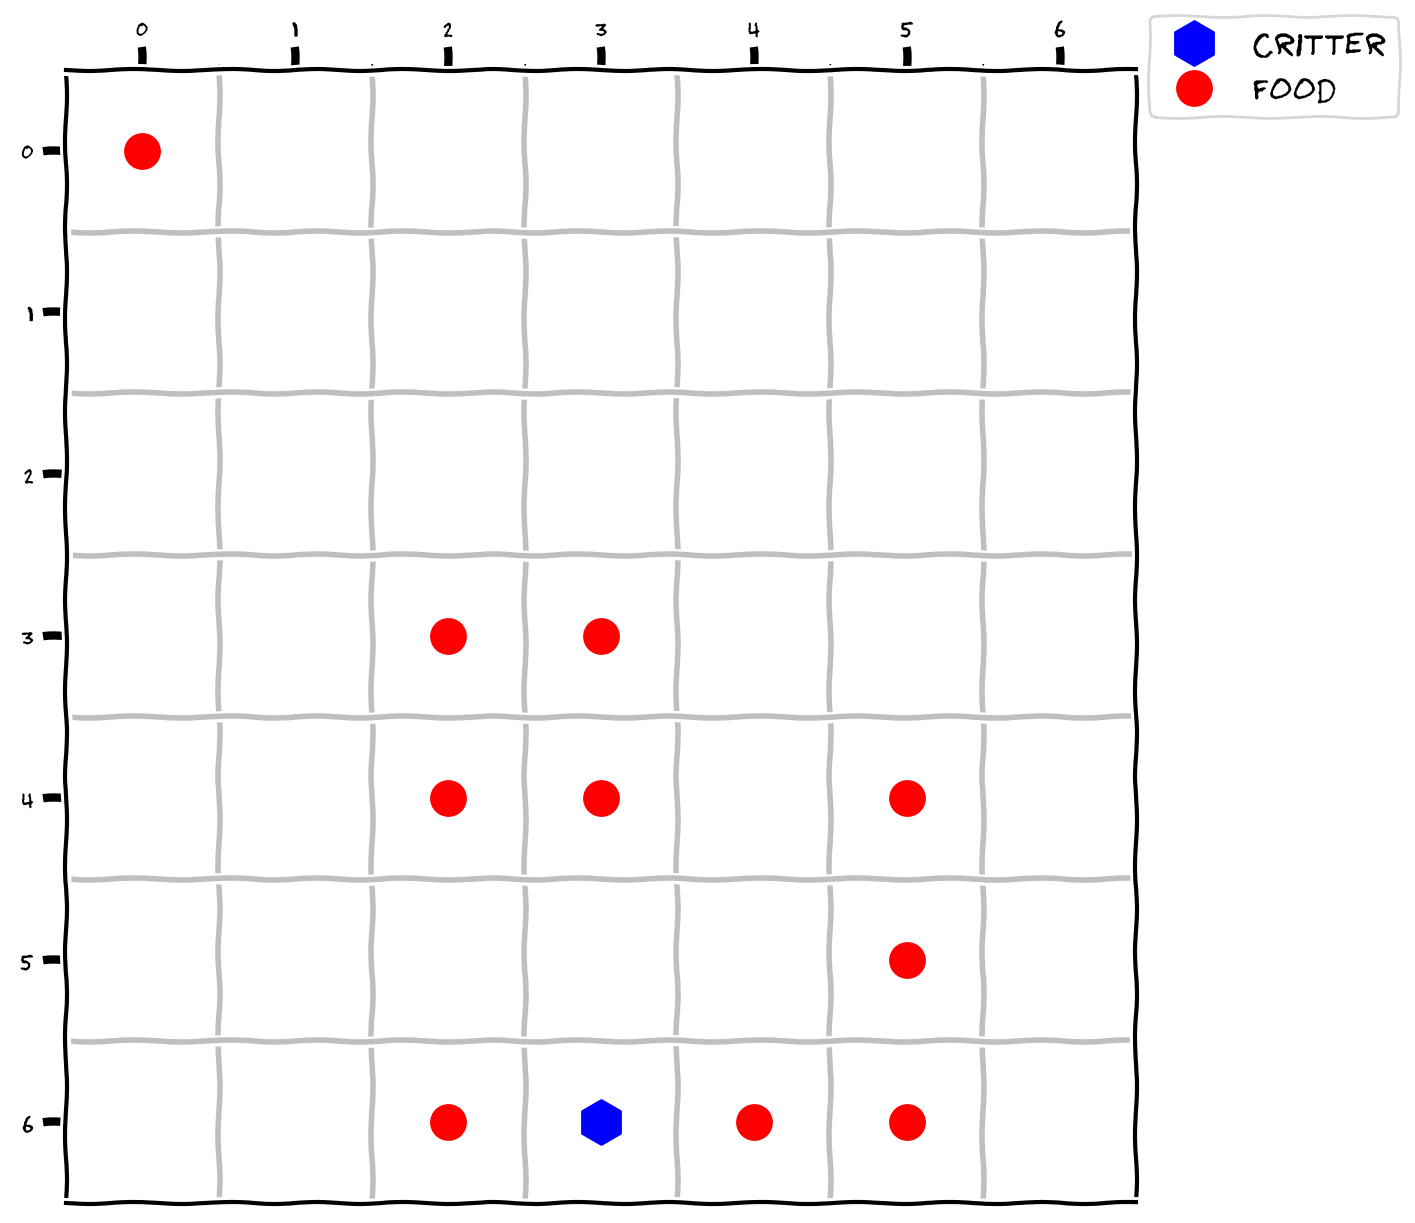

In [52]:
#to_remove solution
def init_loc(n_rows, n_cols, num):
  """
  Samples random 2d grid locations, without replacement,

  Returns:
    int_loc: ndarray(int) of flat indices for a grid
    rc_index: (ndarray(int), ndarray(int)) a pair of arrays the first
      giving the row indices, the second giving the col indices, useful
      for indexing an n_rows by n_cols numpy array
    rc_plotting: ndarray(int) num x 2, same rc coordinates but structured
      in the way that matplotlib likes
  """
  int_loc = np.random.choice(n_rows * n_cols, num, replace=False)
  rc_index = np.unravel_index(int_loc, (n_rows, n_cols))
  rc_plotting = np.fliplr(np.array(rc_index).T)
  return int_loc, rc_index, rc_plotting

with plt.xkcd():
  fig, ax = make_grid(7, 7)
  int_locs, rc_index, rc_plotting = init_loc(7, 7, 11)

  rc_critter = (rc_plotting[0])
  plot_critter(fig, ax, rc_critter, 7)

  rc_food = rc_plotting[1:]
  plot_food(fig, ax, rc_food, 7)

  fig.legend(loc='outside right upper')

In [53]:
# @markdown Vibe Check
content_review("Sequence 1.1.1 Micro 1")

---
# Micro 1.1.1.2: Random Eating

Now that we have an environment scattered with food and an organism, let's introduce some behaviour. The organism drifts around the environment randomly and eats the food it happens to stumble upon. (Can you think of any organisms that employ this strategy?). When food is eaten, the organism gets a **reward**, in this case a *Food Eaten* point, and a new food item appears randomly somewhere else in the environment (that doesn't already have food). Run the code cell below to see what this looks like.

In [ ]:
# @title Random Movement
# @markdown You don't need to worry about how this code works, yet – just **run the cell** for now and watch what happens
display(output)

# 20 random button presses, one every ~3 seconds
state = init_state(n_rows=7, n_cols=7, num_food=10)
for ii in range(30):
  random_click()
  time.sleep(0.1)

*Question:* When the organism is just drifting around randomly how good is it at eating lots of food, what is its efficiency in terms of food per movement? Now run the cell above a few more times. Does the organism always eat the same amount of food or does it change between simulation runs?

In [ ]:
# to_remove explanation

"""
The amount of food eaten varies a lot from simulation run to simulation run,
usually it manages to eat one or two pieces of food, sometimes more sometimes less.
"""

Before we move on it's important to test that our simulation is running as we expect. Randomness can make testing hard, but can overcome in part by setting up the environment in such a way that the outcome becomes deterministic. In the two cells bellow change how the the Gridworld is initialized. By alterning the size, shape and number of food items available create a scenario where the organism will always achieve perfect efficnency and a scenario where the organism will fail completely.

In [ ]:
###############################################################################
# TODO for students: replace ... in init_state(...) to initialize a grid world
# where the organism is always 100% efficient.
raise NotImplementedError("Exercise: make random movement 100% efficient")
################################################################################

display(output)

# 20 random moves, one every ~0.1 seconds
state = init_state(...)
for ii in range(30):
  random_click()
  time.sleep(0.1)

In [ ]:
#to_remove solution

display(output)

# 20 random moves, one every ~0.1 seconds
state = init_state(n_rows=3, n_cols=2, num_food=5)
for ii in range(30):
  random_click()
  time.sleep(0.1)

In [ ]:
###############################################################################
# TODO for students: replace ... in init_state(...) to initialize a grid world
# where the organism is always 0% efficient.
raise NotImplementedError("Exercise: make random movement 0% efficient")
################################################################################

display(output)

# 20 random button presses, one every ~0.1 seconds
state = init_state(...)
for ii in range(30):
  random_click()
  time.sleep(0.1)

In [ ]:
#to_remove solution

display(output)

# 20 random button presses, one every ~0.1 seconds
state = init_state(n_rows=7, n_cols=7, num_food=0)
for ii in range(30):
  random_click()
  time.sleep(0.1)

In [ ]:
# @markdown Vibe Check
content_review("Sequence 1.1.1 Micro 2")

---
# Micro 1.1.1.3: Better Than Random Eating
Now it's your turn to control the organism. Run the next cell and see how much more efficient than random drifting your control of the organism is in terms of food per movement.

In [ ]:
# @title Controlled Movement
# @markdown You don't need to worry about how this code works – just **run the cell** and then use the buttons to guide the organism

# user in control
state = init_state(n_rows=7, n_cols=7, num_food=10)
with output:
  output.clear_output(wait=True)
  print('Press a button')
  plot_fig_from_scratch()
display(widgets.HBox([left_button, widgets.VBox([up_button, down_button]), right_button]), output)

Hopefully your performance was more successful than random flailing. Even in this relatively simple and contrived foraging scenario intelligence can help a lot. What kinds of strategies and heuristics did you use to guide your choice of direction? Essentially, the fundamental purpose of a nervous system and a brain is to solve problems of this kind—deciding which actions to take based on environmental inputs to maximize rewards.

In [ ]:
# @markdown Vibe Check
content_review("Sequence 1.1.1 Micro 3")

---
# Micro 1.1.1.4: Optimal Eating
Finally we'd like to introduce a time traveling super organism, GW7x7-10-30, from the last chapter of this book. GW7x7-10-30 has absolutely mastered 7x7 Gridworld, with 10 food items and a 30 round duration. Run the next cell and see how efficient a highly optimized and specialized Gridworld organism can be. Are you as good as gw7x7-10-30? If not, you gotta read this book 😉 (If you can't beat the AIs, at least learn how to program them.)

(Last chapter not made yet so working on a minimal sketch/skeleton version to produce this agent)

In [ ]:
# @title Optimal Movement
# @markdown You don't need to worry about how this code works – just **run the cell** to watch the super organism behave. See if you can outperform them.

# master organism in control

In [ ]:
# @markdown Vibe Check
content_review("Sequence 1.1.1 Micro 4")

---
# Graveyard


Useful scavenging from github and SO

In [ ]:
out = widgets.Output(layout=widgets.Layout(height='300px'))

x = np.linspace(0,1,100)

def update_plot(w):
    with out:
        # Without clear_output(), figures get appended below each other inside
        # the output widget
        # Ah ha! Got it! I need wait=True!
        out.clear_output(wait=True)
        plt.plot(x, x**p_widget.value)
        plt.show()

p_widget = widgets.FloatSlider(min=0, max=2, step=0.1, value = 1)
update_plot([])
p_widget.observe(update_plot)
display(p_widget, out)

In [ ]:
import ipywidgets as widgets

x = 0
y = {"x": 0}
b = widgets.Button(description="Do it")

def doit(obj):
    print(x, y)
    # x += 1 # uncommenting makes the above print fail
    y["x"] += 1 # this is ok

b.on_click(doit)
display(b)

In [ ]:
# how to get figures to work in this context nicely???
a = widgets.FloatSlider(description='a', min=0, max=10)
b = widgets.FloatSlider(description='b', min=0, max=10)
c = widgets.FloatSlider(description='c', min=0, max=10)

def f(a, b, c):
    print('{}*{}*{}={}'.format(a, b, c, a*b*c))

out = widgets.interactive_output(f, {'a': a, 'b': b, 'c': c})

widgets.HBox([widgets.VBox([a, b, c]), out])

In [ ]:
from matplotlib import animation, rc, patches
from IPython.display import HTML

In [ ]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xticks(np.arange(0, 11, 1))
ax.set_yticks(np.arange(0, 11, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(0, 11, 1))
ax.set_yticklabels(np.arange(0, 11, 1))

# Minor ticks
ax.set_xticks(np.arange(1.5, 10.5, 1), minor=True)
ax.set_yticks(np.arange(1.5, 10.5, 1), minor=True)

# Gridlines based on minor ticks
ax.grid(which='minor', color='grey', linestyle='-', linewidth=2, alpha=0.5)

# Remove minor ticks
ax.tick_params(which='minor', bottom=False, left=False)

ax.set_xlim(( 0.5, 10.5))
ax.set_ylim(( 0.5, 10.5))

#ax.axis("equal")
scatter = ax.scatter([], [])
#critterCircle = plt.Circle((5,5), 0.4)
#dot = ax.add_patch(critterCircle)
#scatter.set_offsets([[5, 5]])

scatter.set_offsets([[3, 11-3]])
#fig.canvas.draw()
#fig.canvas.flush_events()

In [ ]:
def init():
    scatter.set_offsets([[5, 5]])
    return scatter,

In [ ]:
def animate_dot(i):
    print(i)
    x = i
    y = 11-i
    scatter.set_offsets([[x, y]])
    return scatter,

In [ ]:
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate_dot, init_func=init,
                               frames=(np.arange(10)+1), interval=500, blit=True)

In [ ]:
HTML(anim.to_html5_video())

In [ ]:
rc('animation', html='html5')

In [ ]:
anim

These movies are really pretty compared drawing everything from scratch, each time, need to figure out some way to combine the two eventually, but will keep prototyping in janky mode for now.